In [1]:
import pandas as pd
import numpy as np
import torch
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import defaultdict
import albumentations as A

In [2]:
def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

def encode_mask_to_rle(mask):
    """
    mask: numpy array binary mask
    1 - mask
    0 - background
    Returns encoded run length
    """
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [4]:
info_path = '/opt/ml/level2_cv_semanticsegmentation-cv-01/output/hrnet_48w_ocr_1024_augSet_Ensemble_crf_full.csv'

df = pd.read_csv(info_path)
image_info = defaultdict(dict)
image_names = list(set(df['image_name']))
for image_name, class_name, rle in zip(df['image_name'], df['class'], df['rle']):
    image_info[image_name][class_name] = rle

In [5]:
base_path = '/opt/ml/level2_cv_semanticsegmentation-cv-01/data/test/DCM'
i = 0

(29, 2048, 2048)


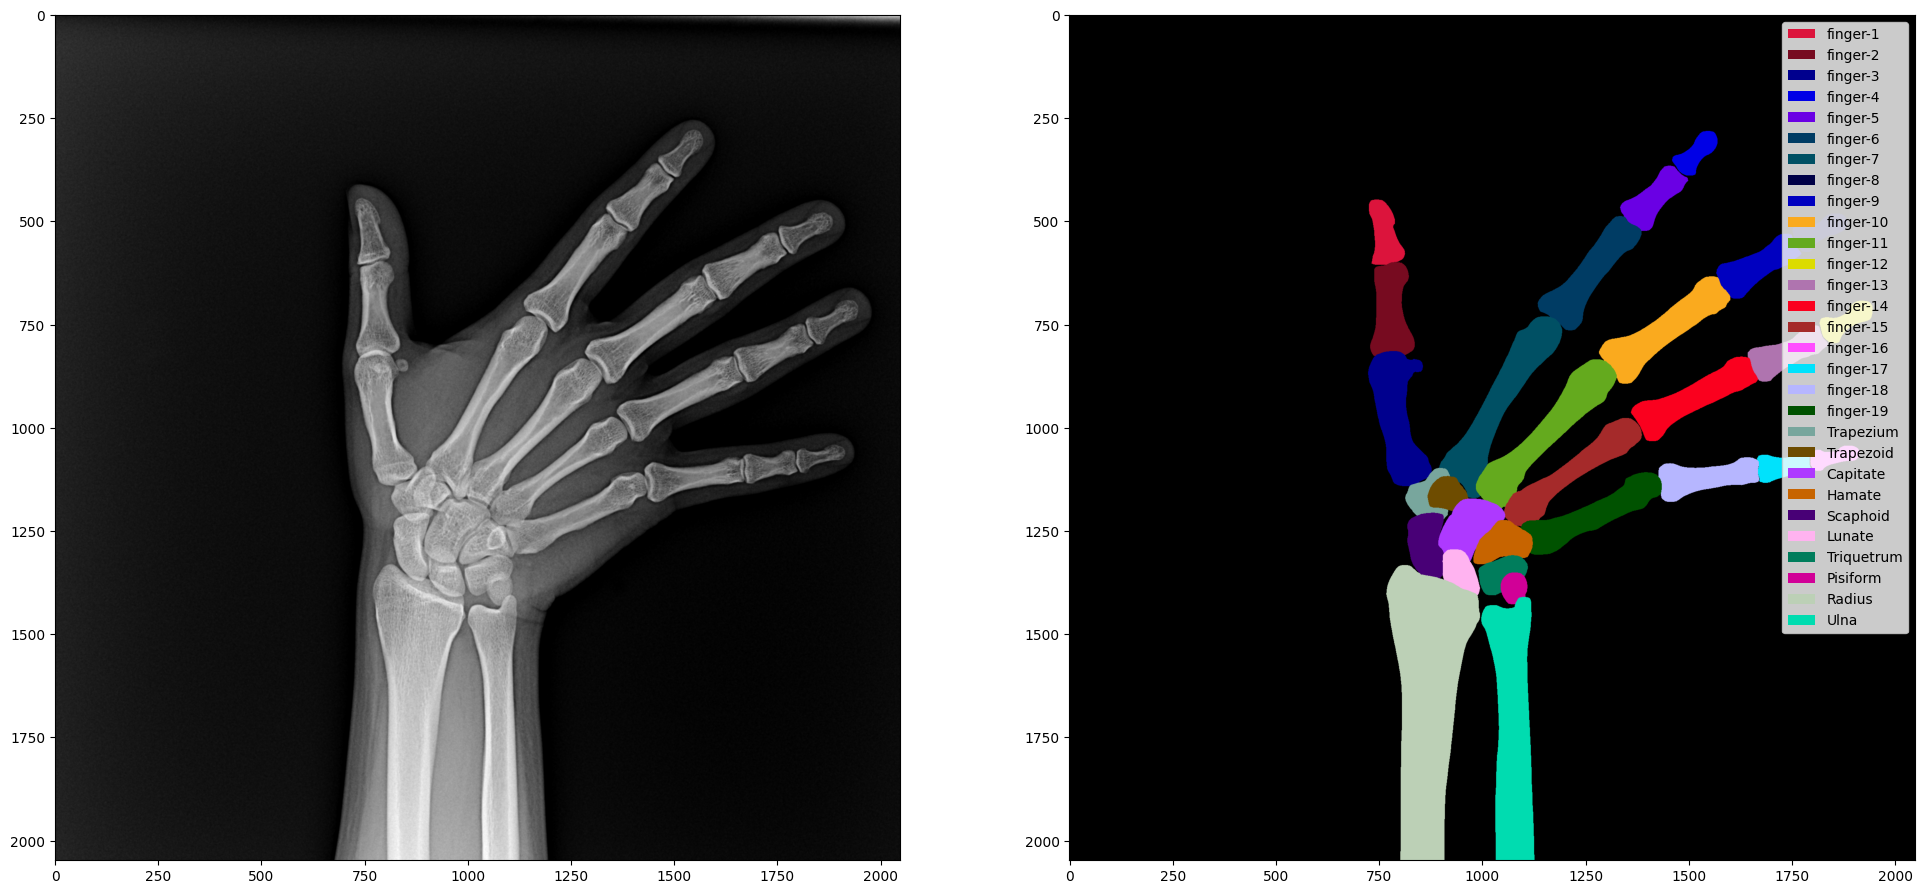

In [6]:
i += 1
image = cv2.imread(os.path.join(base_path, image_names[i]))

preds = []
for class_name, rle in image_info[image_names[i]].items():
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)
print(preds.shape)
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)
ax[1].imshow(label2rgb(preds))

legend_elements = [Patch(facecolor=[c / 255 for c in color], label=CLASSES[i]) for i, color in enumerate(PALETTE)]
plt.legend(handles=legend_elements)
plt.show()

In [ ]:
import numpy as np
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels
from skimage.color import gray2rgb

In [ ]:
# from https://www.kaggle.com/code/meaninglesslives/apply-crf/notebook
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)
#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(10, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 5 steps 
    Q = d.inference(5)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [ ]:
crf_preds = []
for class_name, rle in image_info[image_names[i]].items():
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    crf_output = crf(image, pred)
    crf_preds.append(crf_output)

crf_preds = np.stack(crf_preds, 0)

fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)
ax[1].imshow(label2rgb(crf_preds))

legend_elements = [Patch(facecolor=[c / 255 for c in color], label=CLASSES[i]) for i, color in enumerate(PALETTE)]
plt.legend(handles=legend_elements)
plt.show()

KeyboardInterrupt: 

2265


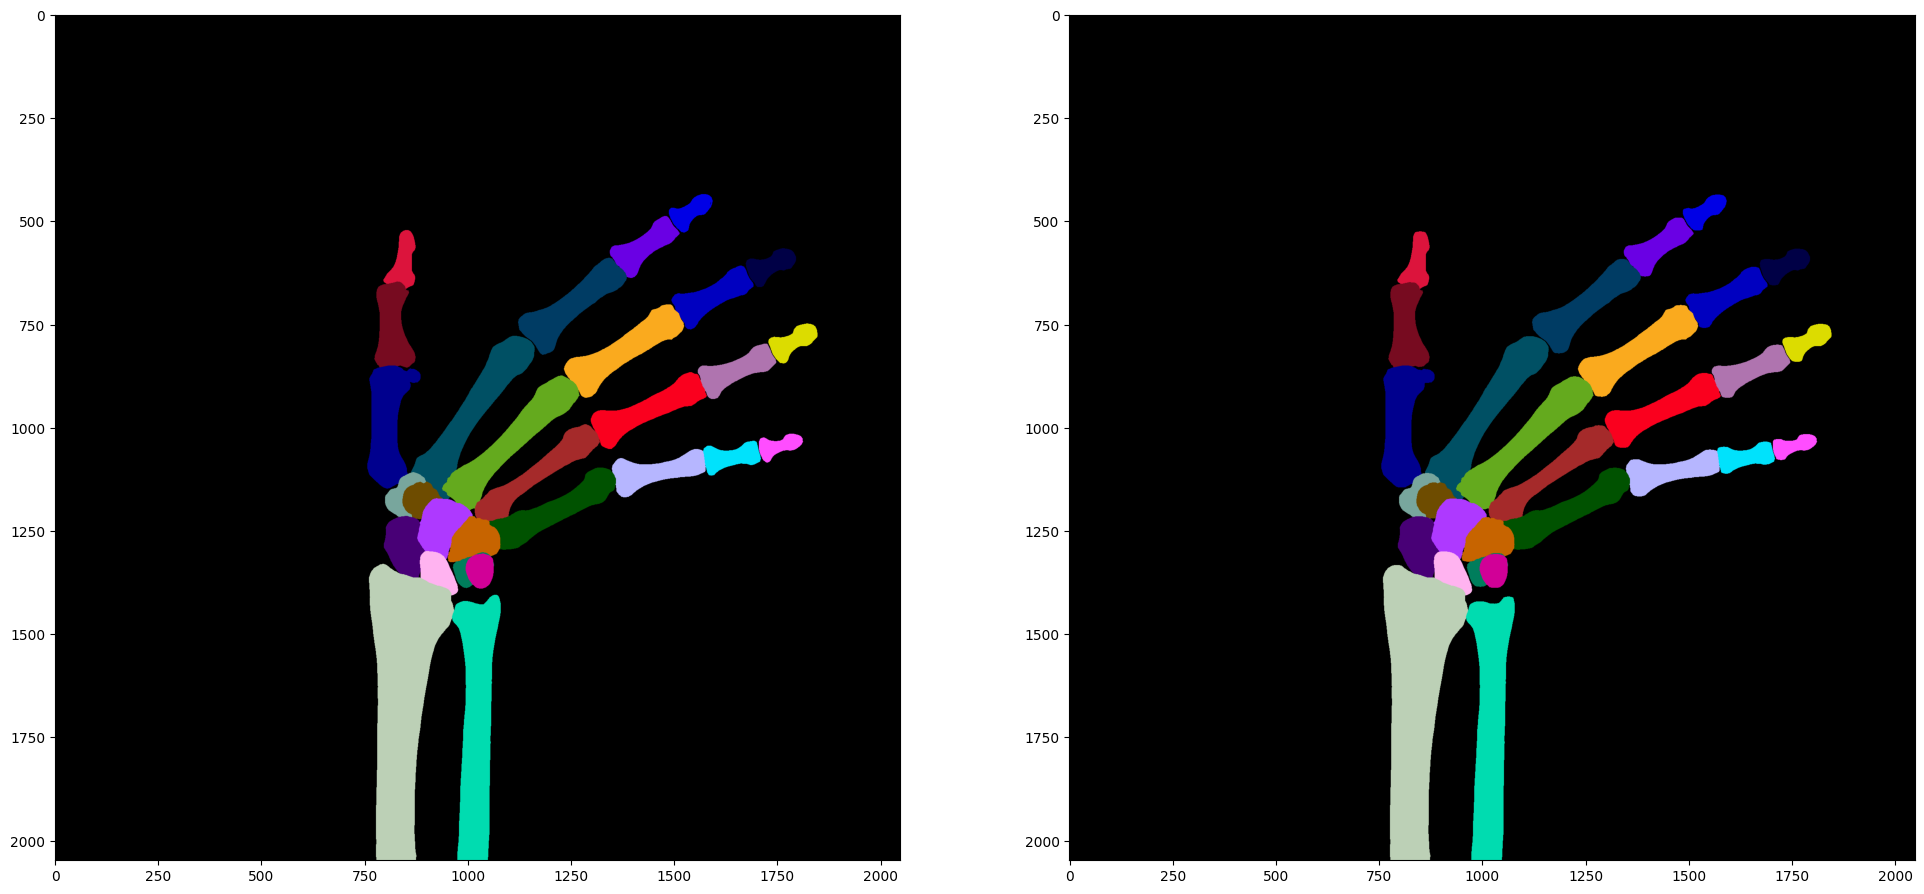

In [ ]:
print(sum(sum(sum(preds != crf_preds))))
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(label2rgb(preds))
ax[1].imshow(label2rgb(crf_preds))

plt.show()

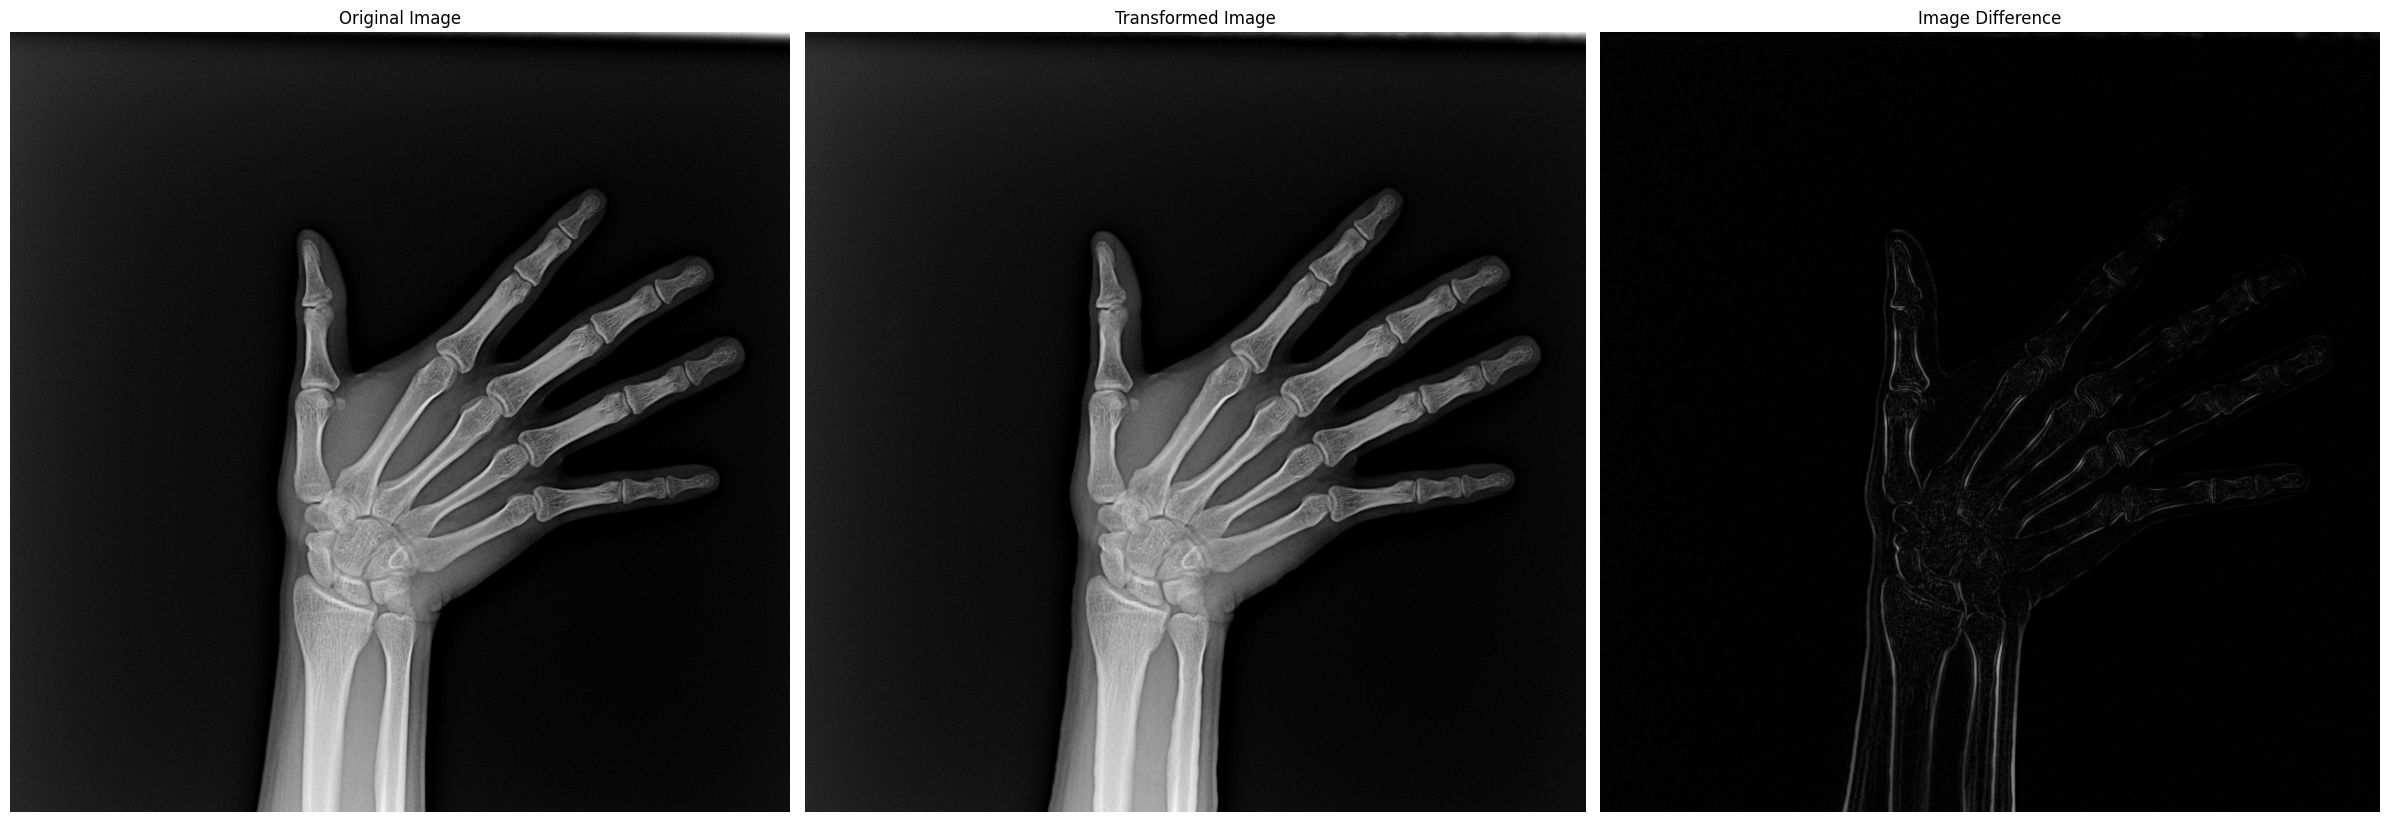

In [ ]:
transform = A.Compose([
    A.ElasticTransform(alpha=50, sigma=10, alpha_affine=10, p=1),
    # 다른 변환 기법 추가alpha=10, sigma=50, alpha_affine=50
])

# 변환된 이미지
transformed_image = transform(image=image)["image"]

image_diff = cv2.absdiff(transformed_image, image)
image_diff_gray = cv2.cvtColor(image_diff, cv2.COLOR_BGR2GRAY)
_, image_diff_binary = cv2.threshold(image_diff_gray, 0, 255, cv2.THRESH_BINARY)


# 이미지 출력
fig, axs = plt.subplots(1, 3, figsize=(24, 12))

# 원본 이미지 출력
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].axis("off")
axs[0].set_title("Original Image")

# 변환된 이미지 출력
axs[1].imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
axs[1].axis("off")
axs[1].set_title("Transformed Image")

# 이미지 차이 출력
axs[2].imshow(cv2.cvtColor(image_diff, cv2.COLOR_BGR2RGB))
axs[2].axis("off")
axs[2].set_title("Image Difference")

plt.tight_layout()
plt.show()